In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
from collections import Counter
pd.set_option('max_columns', 150)
pd.set_option('max_rows', 1000)
sns.set_style('dark')
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook as tqdm
from numba import jit
from sklearn.model_selection import GroupKFold
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import xgboost as xgb

In [44]:
for _, _, files in os.walk('/input/data-science-bowl-2019'):
    print(files)

['sample_submission.csv', 'specs.csv', 'test.csv', 'train.csv', 'train_labels.csv']


In [45]:
#read files
BASE_PATH = '/input/data-science-bowl-2019/'
train = pd.read_csv(BASE_PATH + 'train.csv')
print(f'train shape: {train.shape}')
train_labels = pd.read_csv(BASE_PATH + 'train_labels.csv')
print(f'train_labels shape: {train_labels.shape}')
test = pd.read_csv(BASE_PATH + 'test.csv')
print(f'test shape: {test.shape}')
specs = pd.read_csv(BASE_PATH + 'specs.csv')
print(f'specs shape: {specs.shape}')
sample_submission = pd.read_csv(BASE_PATH + 'sample_submission.csv')
print(f'sample_submission: {sample_submission.shape}')

train shape: (11341042, 11)
train_labels shape: (17690, 7)
test shape: (1156414, 11)
specs shape: (386, 3)
sample_submission: (1000, 2)


In [46]:
train.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,45bb1e1b6b50c07b,2019-09-06T17:53:46.937Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,17eeb7f223665f53,2019-09-06T17:54:17.519Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,77261ab5,0848ef14a8dc6892,2019-09-06T17:54:56.302Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0001e90f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
3,b2dba42b,0848ef14a8dc6892,2019-09-06T17:54:56.387Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,2,3010,53,Sandcastle Builder (Activity),Activity,MAGMAPEAK
4,1bb5fbdb,0848ef14a8dc6892,2019-09-06T17:55:03.253Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,3,3110,6972,Sandcastle Builder (Activity),Activity,MAGMAPEAK


In [47]:
test.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,0ea9ecc81a565215,2019-09-10T16:50:24.910Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,c1ea43d8b8261d27,2019-09-10T16:50:55.503Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,27253bdc,7ed86c6b72e725e2,2019-09-10T16:51:51.805Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 2,Clip,MAGMAPEAK
3,27253bdc,7e516ace50e7fe67,2019-09-10T16:53:12.825Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Crystal Caves - Level 1,Clip,CRYSTALCAVES
4,7d093bf9,a022c3f60ba547e7,2019-09-10T16:54:12.115Z,"{""version"":""1.0"",""round"":0,""event_count"":1,""ga...",00abaee7,1,2000,0,Chow Time,Game,CRYSTALCAVES


In [48]:
test[test.type=='Assessment'].head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
282,7ad3efc6,8b38fc0d2fd315dc,2019-09-11T18:56:11.918Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",00abaee7,1,2000,0,Cart Balancer (Assessment),Assessment,CRYSTALCAVES
283,65a38bf7,8b38fc0d2fd315dc,2019-09-11T18:56:12.019Z,"{""crystals"":[{""id"":""gem07"",""weight"":6},{""id"":""...",00abaee7,2,2020,58,Cart Balancer (Assessment),Assessment,CRYSTALCAVES
284,795e4a37,8b38fc0d2fd315dc,2019-09-11T18:56:12.030Z,"{""description"":""We've got to balance this scal...",00abaee7,3,3010,58,Cart Balancer (Assessment),Assessment,CRYSTALCAVES
285,5e109ec3,8b38fc0d2fd315dc,2019-09-11T18:56:15.790Z,"{""crystal_id"":""gem07"",""weight"":6,""coordinates""...",00abaee7,4,4030,3852,Cart Balancer (Assessment),Assessment,CRYSTALCAVES
286,5c2f29ca,8b38fc0d2fd315dc,2019-09-11T18:56:17.869Z,"{""crystal_id"":""gem07"",""weight"":6,""coordinates""...",00abaee7,5,4020,5968,Cart Balancer (Assessment),Assessment,CRYSTALCAVES


In [49]:
test.groupby(['installation_id', 'title'])['game_time'].agg('mean')

installation_id  title                       
00abaee7         12 Monkeys                           0.000000
                 All Star Sorting                172785.392405
                 Balancing Act                        0.000000
                 Bug Measurer (Activity)          10310.076923
                 Cart Balancer (Assessment)       14546.846154
                                                     ...      
ffe774cc         Bird Measurer (Assessment)           0.000000
                 Mushroom Sorter (Assessment)     15342.048780
                 Pirate's Tale                        0.000000
                 Tree Top City - Level 2              0.000000
                 Tree Top City - Level 3              0.000000
Name: game_time, Length: 15591, dtype: float64

In [50]:
sample_submission.head()

,installation_id,accuracy_group
0,00abaee7,3
1,01242218,3
2,017c5718,3
3,01a44906,3
4,01bc6cb6,3


In [51]:
train_labels.head()

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.0,0
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.5,2
4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.0,3


In [52]:
keep_id = train[train.type == "Assessment"][['installation_id']].drop_duplicates()
train = pd.merge(train, keep_id, on="installation_id", how="inner")
print(f'remove installation_id who never made assessment')
print(f'new train shape: {train.shape}')

remove installation_id who never made assessment
new train shape: (8294138, 11)


(-1, 10)

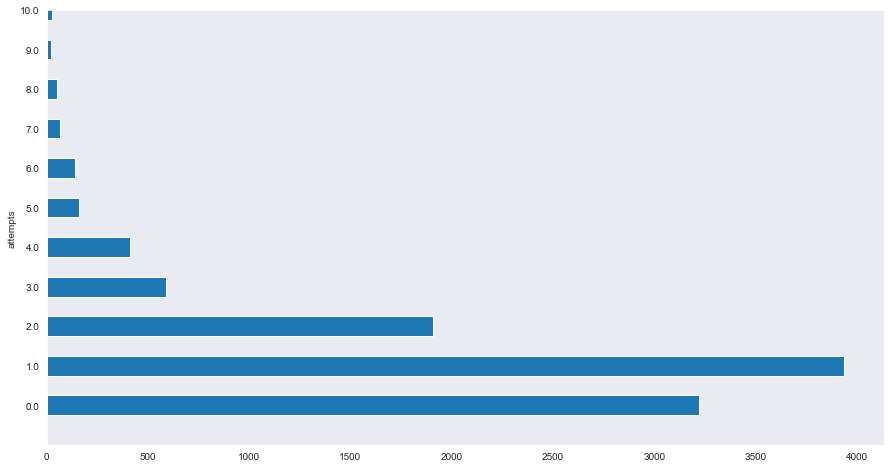

In [53]:
train['attempts'] = train[(train.event_code == 4100) |
      (train.event_code == 4110) &
      (train.type == 'Assessment')]['event_data'].apply(lambda x: 1 if 'true' in x else 0)
att_count = train[train.type == 'Assessment'].groupby(['installation_id', 'title'])['attempts'].agg(np.sum)
att = pd.DataFrame(att_count).reset_index()
att.groupby('attempts')['installation_id'].agg('count').plot(kind='barh', figsize=(15, 8))
plt.ylim(-1, 10)

In [54]:
def get_time(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date
    df['month'] = df['timestamp'].dt.month
    df['hour'] = df['timestamp'].dt.hour
    df['dayofweek'] = df['timestamp'].dt.dayofweek
    return df

train = get_time(train)
test = get_time(test)

In [55]:
train['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), train['title'], train['event_code']))
test['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), test['title'], test['event_code']))

train['world_type'] = list(map(lambda x, y: str(x) + '_' + str(y), train['world'], train['type']))
test['world_type'] = list(map(lambda x, y: str(x) + '_' + str(y), test['world'], test['type']))

all_title_event_code = list(set(train['title_event_code'].unique()).union(set(test['title_event_code'].unique())))
list_of_title = list(set(train['title'].unique()).union(set(test['title'].unique())))
list_of_event_code = list(set(train['event_code'].unique()).union(set(test['event_code'].unique())))
list_of_event_id = list(set(train['event_id'].unique()).union(set(test['event_id'])))
list_of_world = list(set(train['world'].unique()).union(set(test['world'].unique())))
list_of_world_type = list(set(train['world_type'].unique()).union(set(test['world_type'].unique())))
list_of_assessment = list(set(train[train.type == 'Assessment']['title'].unique()).union(set(test[test.type == 'Assessment']['title'].unique())))
list_of_event_id = list(set(train['event_id'].unique()).union(set(test['event_id'].unique())))

title_map = dict(zip(list_of_title, np.arange(len(list_of_title))))
title_labels = dict(zip(np.arange(len(list_of_title)), list_of_title))
world_map = dict(zip(list_of_world, np.arange(len(list_of_world))))
world_labels = dict(zip(np.arange(len(list_of_world)), list_of_world))
world_type_map = dict(zip(list_of_world_type, np.arange(len(list_of_world_type))))
world_type_labels = dict(zip(np.arange(len(list_of_world_type)), list_of_world_type))

train['title'] = train['title'].map(title_map)
test['title'] = test['title'].map(title_map)
train['world'] = train['world'].map(world_map)
test['world'] = test['world'].map(world_map)
train['world_type'] = train['world_type'].map(world_type_map)
test['world_type'] = test['world_type'].map(world_type_map)

In [56]:
def get_data(df, test_set=False):
    
    all_data = []
    act_type = {'Clip': 0, 'Activity': 0, 'Assessment': 0, 'Game': 0}
    world_act_time_dir = {wt: 0 for wt in list_of_world_type}
    world_time_dir = {wo: 0 for wo in list_of_world}
    event_count_dir = {ev: 0 for ev in list_of_event_code}
    title_time_dir = {ti: 0 for ti in list_of_title}
    assessment_title_count = {at: 0 for at in list_of_assessment}
    event_id_dir = {ei: 0 for ei in list_of_event_id}
    acc_attempt_total = 0
    acc_attempt_true = 0
    acc_attempt_false = 0
    acc_accuracy = 0
    acc_accuracy_group = {0:0, 1:0, 2:0, 3:0}
    acc_time = 0
    assess_count = 0
    sess_duration = 0
    done_before = 0
    durations = []
    
    for i, game_sess in df.groupby('game_session', sort=False):
        
        sess_type = game_sess['type'].iloc[0]
        sess_title = game_sess['title'].iloc[0]
        sess_world = game_sess['world'].iloc[0]
        sess_world_type = game_sess['world_type'].iloc[0]

        
        time = int(game_sess['game_time'].iloc[-1]/1000)
        if sess_type != 'Assessment':
            acc_time += time
            world_time_dir[world_labels[sess_world]] += time
            id_list = game_sess['event_id'].unique()
            for ev_id in id_list:
                event_id_dir[ev_id] += 1
            
        if (sess_type == 'Assessment') & (test_set or len(game_sess) > 1):
            
            attempt_total = game_sess.query('event_code == 4100 or event_code == 4110')['event_data'].shape[0]
            attempt_true = game_sess.query('event_code == 4100 or event_code == 4110')['event_data'].str.contains('true').sum()
            attempt_false = game_sess.query('event_code == 4100 or event_code == 4110')['event_data'].str.contains('false').sum()
            
            #assess_duration = (game_sess.timestamp.iloc[-1] - game_sess.timestamp.iloc[0]).seconds
            accuracy = attempt_true / attempt_total
            
            if attempt_total is not None:
                if accuracy == 0:
                    accuracy_group = 0
                elif accuracy == 1:
                    accuracy_group = 3
                elif accuracy == 0.5:
                    accuracy_group = 2
                else:
                    accuracy_group = 1

            features = act_type.copy()
            features['session_title'] = sess_title
            done_before = assessment_title_count[title_labels[sess_title]]
            features['done_before'] = done_before
            features['acc_time'] = acc_time
            if durations == []:
                features['duration_mean'] = 0
            else:
                features['duration_mean'] = np.mean(durations)
            durations.append((game_sess['timestamp'].iloc[-1] - game_sess['timestamp'].iloc[0]).seconds)
            features['acc_attempt_ttl'] = acc_attempt_total
            features['acc_attempt_true'] = acc_attempt_true
            features['acc_attempt_false'] = acc_attempt_false
            features['accuracy_group'] = accuracy_group
            if acc_attempt_total != 0:
                acc_accuracy = acc_attempt_true / acc_attempt_total
            features['acc_accuracy'] = acc_accuracy
            features.update(acc_accuracy_group)
            features['installation_id'] = game_sess['installation_id'].iloc[-1]
            features.update(event_count_dir)
            features.update(title_time_dir)
            features.update(world_time_dir)
            features.update(world_act_time_dir)
            features.update(event_id_dir)
            
            if test_set:
                all_data = features
            else:
                all_data.append(features)
            
            #accumulate counter
            acc_attempt_total += attempt_total
            acc_attempt_true += attempt_true
            acc_attempt_false += attempt_false
            acc_accuracy_group[accuracy_group] += 1
            
            #in the past witch times to do the assessment
            assessment_title_count[title_labels[sess_title]] += 1
            
        #time

        world_act_time_dir[world_type_labels[sess_world_type]] += time
        title_time_dir[title_labels[sess_title]] += time   
        
        #event_count
        event_code_counter = Counter(game_sess['event_code'])
        for eve in event_code_counter.keys():
            event_count_dir[eve] += event_code_counter[eve]
            
        #act_count
        act_type[sess_type] += 1
        
    return all_data

In [57]:
compile_data = []
for i, (ins_id, act) in tqdm(enumerate(train.groupby('installation_id', sort=False)),
                             total=train.installation_id.nunique(),
                             desc='Installation_id',
                             position=0
                            ):
    compile_data += get_data(act)

In [87]:
reduce_test = []
for i, (ins_id, act) in tqdm(enumerate(test.groupby('installation_id', sort=False)),
                              total=test.installation_id.nunique(),
                              desc='Installation_id',
                              position=0
                             ):
    reduce_test.append(get_data(act, test_set=True))

In [88]:
train[train.installation_id == '0006a69f'].head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,attempts,date,month,hour,dayofweek,title_event_code,world_type
0,27253bdc,34ba1a28d02ba8ba,2019-08-06 04:57:18.904000+00:00,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,34,Clip,2,NaN,2019-08-06,8,4,1,Welcome to Lost Lagoon!_2000,7
1,27253bdc,4b57c9a59474a1b9,2019-08-06 04:57:45.301000+00:00,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,42,Clip,0,NaN,2019-08-06,8,4,1,Magma Peak - Level 1_2000,0
2,77261ab5,2b9d5af79bcdb79f,2019-08-06 04:58:14.538000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0006a69f,1,2000,0,26,Activity,0,NaN,2019-08-06,8,4,1,Sandcastle Builder (Activity)_2000,5
3,b2dba42b,2b9d5af79bcdb79f,2019-08-06 04:58:14.615000+00:00,"{""description"":""Let's build a sandcastle! Firs...",0006a69f,2,3010,29,26,Activity,0,NaN,2019-08-06,8,4,1,Sandcastle Builder (Activity)_3010,5
4,1325467d,2b9d5af79bcdb79f,2019-08-06 04:58:16.680000+00:00,"{""coordinates"":{""x"":273,""y"":650,""stage_width"":...",0006a69f,3,4070,2137,26,Activity,0,NaN,2019-08-06,8,4,1,Sandcastle Builder (Activity)_4070,5


In [89]:
sample = train[train.installation_id == '0006a69f']

In [90]:
aa = get_data(sample)
pd.DataFrame(aa)

,Clip,Activity,Assessment,Game,session_title,done_before,acc_time,duration_mean,acc_attempt_ttl,acc_attempt_true,acc_attempt_false,accuracy_group,acc_accuracy,0,1,2,3,installation_id,2050,4100,2060,4110,2070,2075,2080,2081,2083,3110,3120,3121,4220,4230,5000,4235,5010,4010,4020,4021,4022,4025,4030,4031,3010,4035,4040,3020,3021,4045,2000,4050,2010,2020,4070,2025,2030,4080,2035,2040,4090,4095,Fireworks (Activity),Cauldron Filler (Assessment),Balancing Act,Flower Waterer (Activity),"Heavy, Heavier, Heaviest",Pan Balance,Crystal Caves - Level 3,Tree Top City - Level 1,Tree Top City - Level 3,Treasure Map,Chicken Balancer (Activity),Bug Measurer (Activity),Mushroom Sorter (Assessment),Bottle Filler (Activity),Crystal Caves - Level 2,...,f54238ee,16667cc5,c51d8688,ea321fb1,a29c5338,ab4ec3a4,bcceccc6,b2e5b0f1,7ab78247,47efca07,763fc34e,7961e599,77261ab5,4b5efe37,cf7638f3,6f8106d9,c1cac9a2,28ed704e,5154fc30,6f445b57,dcb1663e,e7561dd2,3a4be871,7525289a,28520915,26a5a3dd,6088b756,65a38bf7,0330ab6a,93b353f2,a8a78786,17113b36,532a2afb,b120f2ac,19967db1,88d4a5be,0d1da71f,0086365d,e57dd7af,0d18d96c,92687c59,9ee1c98c,2dc29e21,6043a2b4,17ca3959,b74258a0,69fdac0a,eb2c19cd,9b23e8ee,1cf54632,d3268efa,db02c830,67439901,fd20ea40,1af8be29,37ee8496,5b49460a,90efca10,38074c54,cfbd47c8,86c924c4,3bb91dda,77ead60d,bb3e370b,ca11f653,2a444e03,363d3849,29bdd9ba,cf82af56,2230fab4,44cb4907,119b5b02,9de5e594,598f4598,d2659ab4
0,11,3,0,4,12,0,622,0.000000,0,0,0,3,0.000000,0,0,0,0,0006a69f,6,0,0,0,0,0,4,1,2,77,7,9,0,0,0,0,0,4,92,14,31,19,121,0,79,1,0,7,9,0,18,0,0,20,94,4,18,0,0,6,4,0,91,0,0,164,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,1,3,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3,0,1,0,0,0,0,1,0
1,14,4,1,6,30,0,997,39.000000,1,1,0,0,1.000000,0,0,0,1,0006a69f,6,5,1,2,1,0,4,1,2,223,11,16,0,0,0,0,0,6,127,14,31,37,149,0,226,6,2,11,16,0,25,0,1,26,156,5,22,0,1,6,4,0,91,0,0,164,0,0,0,0,0,0,0,104,39,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,1,3,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,1,3,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,3,0,1,0,1,0,0,1,0
2,14,4,2,6,12,1,997,65.500000,12,1,11,3,0.083333,1,0,0,1,0006a69f,6,5,1,13,1,0,4,1,2,225,22,16,0,0,0,0,0,6,127,14,31,59,171,0,228,6,2,22,16,0,26,0,1,27,160,5,22,0,1,6,4,0,91,0,0,164,0,0,0,0,0,0,0,104,39,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,1,3,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,1,3,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,3,0,1,0,1,0,0,1,0
3,24,9,3,10,12,2,3278,52.333333,13,2,11,1,0.153846,1,0,0,2,0006a69f,9,6,2,13,2,0,8,2,5,334,25,37,9,0,5,0,5,10,243,29,45,90,314,6,339,14,9,25,37,2,46,0,2,51,348,8,43,0,4,10,4,1,1611,0,0,254,0,0,0,0,0,0,0,104,65,165,0,...,0,0,0,0,1,0,1,0,0,0,0,0,2,4,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,2,4,2,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,1,1,1,2,0,4,0,2,0,1,0,0,2,0
4,24,9,4,10,12,3,3278,41.250000,13,2,11,2,0.153846,1,1,0,2,0006a69f,9,6,2,13,2,0,8,2,5,336,25,40,9,0,5,0,5,10,243,29,45,93,314,6,341,14,9,25,40,2,47,0,2,52,348,9,43,0,5,10,4,1,1611,0,0,254,0,0,0,0,0,0,0,104,73,165,0,...,0,0,0,0,1,0,1,0,0,0,0,0,2,4,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,2,4,2,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,1,1,1,2,0,4,0,2,0,1,0,0,2,0
5,28,10,5,13,30,1,3733,39.200000,15,3,12,3,0.200000,1,1,1,2,0006a69f,9,12,3,13,2,1,8,2,5,457,30,53,9,0,5,0,5,12,277,29,45,105,331,6,463,15,10,30,53,2,56,0,3,64,387,10,53,0,6,10,4,1,1611,0,0,254,0,0,0,0,0,0,0,184,104,165,0,...,0,0,0,0,1,0,2,0,0,0,0,0,2,4,0,0,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,2,4,2,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,2,1,1,1,2,0,4,0,2,0,2,0,0,2,1


In [ ]:
re_train = pd.DataFrame(compile_data)
print(f're_train dataframe shape: {re_train.shape}')
re_train.head()

In [ ]:
re_test = pd.DataFrame(reduce_test)
print(f're_test dataframe shape: {re_test.shape}')

In [ ]:
re_test.head()

In [ ]:
def preprocess(re_train, re_test):
    for df in [re_train, re_test]:
        df['installation_session_count'] = df.groupby('installation_id')['Clip'].transform('count')
        df['installation_duration_time'] = df.groupby('installation_id')['duration_mean'].transform('mean')
        df['installation_title_nunique'] = df.groupby('installation_id')['session_title'].transform('nunique')
        
        df['sum_event_code_count'] = df[[2000, 3010, 4070, 3110, 4030, 4021, 4020,
                                         4090, 4010, 2080, 2081, 2020, 2040, 2030,
                                         3021, 3121, 2050, 3020, 3120, 2083, 2025,
                                         4035, 4025, 4022, 2035, 4040, 4100, 2010,
                                         2060, 2070, 4110, 5000, 5010, 4031, 4045,
                                         4095, 4220, 2075, 4230, 4235, 4080, 4050]].sum(axis=1)
        df['installation_event_code_count_mean'] = df.groupby('installation_id')['sum_event_code_count'].transform('mean')        
        
        features = re_train.loc[(re_train.sum(axis=1) != 0), (re_train.sum(axis=0) != 0)].columns
        
    return re_train[features], re_test[features], features
    
re_train, re_test, features = preprocess(re_train, re_test)       

In [ ]:
re_train.shape

In [ ]:
y = re_train['accuracy_group']
X = re_train.drop(columns=['accuracy_group'], axis=1)

In [ ]:
print(X.shape, y.shape)

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
@jit
def qwk(a1, a2):
    """
    Source: https://www.kaggle.com/c/data-science-bowl-2019/discussion/114133#latest-660168

    :param a1:
    :param a2:
    :param max_rat:
    :return:
    """
    max_rat = 3
    a1 = np.asarray(a1, dtype=int)
    a2 = np.asarray(a2, dtype=int)

    hist1 = np.zeros((max_rat + 1, ))
    hist2 = np.zeros((max_rat + 1, ))

    o = 0
    for k in range(a1.shape[0]):
        i, j = a1[k], a2[k]
        hist1[i] += 1
        hist2[j] += 1
        o +=  (i - j) * (i - j)

    e = 0
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            e += hist1[i] * hist2[j] * (i - j) * (i - j)

    e = e / a1.shape[0]

    return 1 - o / e


def eval_qwk_lgb(y_true, y_pred):
    """
    Fast cappa eval function for lgb.
    """

    y_pred = y_pred.reshape(len(np.unique(y_true)), -1).argmax(axis=0)
    return 'cappa', qwk(y_true, y_pred), True


def eval_qwk_lgb_regr(y_true, y_pred):
    """
    Fast cappa eval function for lgb.
    """
    y_pred[y_pred <= 1.05408096] = 0
    y_pred[np.where(np.logical_and(y_pred > 1.05408096, y_pred <= 1.69221444))] = 1
    y_pred[np.where(np.logical_and(y_pred > 1.69221444, y_pred <= 2.18179548))] = 2
    y_pred[y_pred > 2.18179548] = 3
    # y_pred = y_pred.reshape(len(np.unique(y_true)), -1).argmax(axis=0)

    return 'cappa', qwk(y_true, y_pred), True

In [ ]:
params = {'n_estimators': 2000,
          'boostin_type': 'gdbt',
          'objective': 'regression',
          'metric': 'rmse',
          'subsample': 0.75,
          'subsample': 1,
          'learning': 0.04,
          'feature_fraction': 0.9,
          'max_depth': 15,
          'lambda_l1': 1,
          'lambda_l2': 1,
          'verbose': 0,
          'early_stopping_rounds': 100,
          'eval_metric': 'cappa'
         }

In [ ]:
X.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X.columns]

RandomForestRegressor(bootstrap=False, 
                                  max_features='auto',
                                  min_samples_leaf=15,
                                  min_samples_split=7,
                                  n_estimators=2000,
                                  criterion='mse',
                                  n_jobs=-1,
                                  #verbose=100,
                                  random_state=46)

In [ ]:
n_fold = 5
models = []
KFold = GroupKFold(n_splits=n_fold)
for i, (train_idx, val_idx) in enumerate(KFold.split(X, y, X['installation_id'])):
    X_r = X.drop(columns=['installation_id'], axis=1)
    X_train, y_train, X_val, y_val = X_r.iloc[train_idx], y.iloc[train_idx], X_r.iloc[val_idx], y.iloc[val_idx]
    print(f'Fold : {i}')
    model = lgb.LGBMRegressor()
    model = model.set_params(**params)
    model.fit(X=X_train, y=y_train,
              eval_set=[(X_train, y_train), (X_val, y_val)],
              eval_metric=eval_qwk_lgb_regr,
              early_stopping_rounds=params['early_stopping_rounds'])
    models.append(model)

In [ ]:
from functools import partial
import scipy as sp
class OptimizedRounder(object):
    """
    An optimizer for rounding thresholds
    to maximize Quadratic Weighted Kappa (QWK) score
    # https://www.kaggle.com/naveenasaithambi/optimizedrounder-improved
    """
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        """
        Get loss according to
        using current coefficients
        
        :param coef: A list of coefficients that will be used for rounding
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        X_p = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3])

        return -qwk(y, X_p)

    def fit(self, X, y):
        """
        Optimize rounding thresholds
        
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        """
        Make predictions with specified thresholds
        
        :param X: The raw predictions
        :param coef: A list of coefficients that will be used for rounding
        """
        return pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3])


    def coefficients(self):
        """
        Return the optimized coefficients
        """
        return self.coef_['x']

In [ ]:
feature_importance = list(zip(X_r.columns, list(model.feature_importances_)))
dt = pd.DataFrame(feature_importance,  columns=['feature' ,'importance'])
dt.sort_values(by=['importance'], ascending=False).head(20)

In [ ]:
fig = plt.figure(figsize=(14, 8))
dt.sort_values(by=['importance'], ascending=False).head(20).plot(kind='barh')
plt.show()

In [ ]:
%%time
pr_sum = np.zeros((y.shape))
for model in models:
    pr = model.predict(X_r)
    pr_sum += pr
pr1 = pr_sum / len(models)
optR = OptimizedRounder()
optR.fit(pr1.reshape(-1,), y)
coefficients = optR.coefficients()

%%time
pr1 = model.predict(X_r)

optR = OptimizedRounder()
optR.fit(pr1.reshape(-1,), y)
coefficients = optR.coefficients()

In [ ]:
coefficients

In [ ]:
opt_preds = optR.predict(pr1.reshape(-1, ), coefficients)
qwk(y, opt_preds)

In [ ]:
re_test.drop(columns=['installation_id', 'accuracy_group'], axis=1, inplace=True)

In [ ]:
%%time
pr_sum = np.zeros((re_test.shape[0]))
for model in models:
    pr = model.predict(re_test)
    pr_sum += pr
y_pred = pr_sum / len(models)

In [ ]:
list(y_pred)[:10]

In [ ]:
y_pred[y_pred <= coefficients[0]] = 0
y_pred[np.where(np.logical_and(y_pred > coefficients[0], y_pred <= coefficients[1]))] = 1
y_pred[np.where(np.logical_and(y_pred > coefficients[1], y_pred <= coefficients[2]))] = 2
y_pred[y_pred > coefficients[2]] = 3

In [ ]:
list(y_pred)[:10]

In [ ]:
sample_submission['accuracy_group'] = y_pred.astype(int)
sample_submission.to_csv('submission.csv', index=False)